### GWR example
***
This is a basic example notebook demostrate  how to calibrate a GWR (Fotheringham et al., 2002) model in Python using the open-source `mgwr` package. The mgwr package is developed by Oshan et al. (2019), and it is hosted at https://github.com/pysal/mgwr.

#### Installation
`pip install mgwr`

In [1]:
#!pip install mgwr


We will be working on an example dataset of Georgia, and here are some variables in the data.

**TotPop90** Population of the county in 1990

**PctRural** Percentage of the county population defined as rural

**PctBach** Percentage of the county population with a bachelor’s degree 

**PctEld** Percentage of the county population aged 65 or over

**PctFB** Percentage of the county population born outside the US 

**PctPov** Percentage of the county population living below the poverty line 

**PctBlack** Percentage of the county population who are black  


***
We will model the county-level educational attainment with several socio-demographic variables.  

***
The model is:  

PctBach = b0 + b1 * PctFB + b2 * PctBlack + b3 * PctRural




Load packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps 
from libpysal.weights import Queen
from esda.moran import Moran

#MGWR functions
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

Load Georgia dataset from pysal

In [3]:
georgia_shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/georgia.geojson")

The map of Georgia and the centorid of each county.

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_55115/3938808638.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  georgia_shp.centroid.plot(ax=ax, c='black',markersize = 10,aspect=1)


<Axes: >

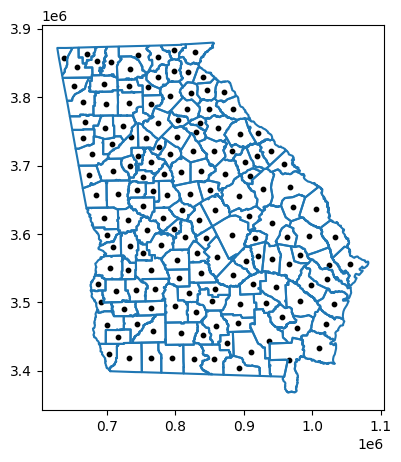

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
georgia_shp.boundary.plot(ax=ax,aspect=1)

georgia_shp.centroid.plot(ax=ax, c='black',markersize = 10,aspect=1)

A map of Georgia for reference 
(source:https://www.enchantedlearning.com/usa/states/georgia/map.GIF)


<img src=https://www.enchantedlearning.com/usa/states/georgia/map.GIF width="200" align="left">

We could map the dependent variable "PctBach".

Text(0.5, 1.0, 'PctBach')

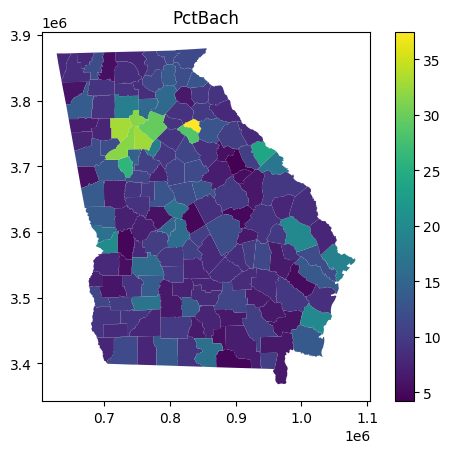

In [5]:
georgia_shp.plot(column="PctBach",legend=True,aspect=1)
plt.title("PctBach")

#### Model specification: 
PctBach = b0 + b1 * PctFB + b2 * PctBlack + b3 * PctRural
***
Prepare Georgia dataset to be input to mgwr

In [6]:
y = georgia_shp['PctBach'].values

X = georgia_shp[['PctFB', 'PctBlack', 'PctRural']].values

u = georgia_shp['X']
v = georgia_shp['Y']

coords = list(zip(u,v))

### Standardizing varaibles (optional)
- Standardize the data to have mean of 0 and variance of 1.
- The magnitudes of the parameter estimates are comparable. Larger coefficient -> stronger relationship.

In [7]:
#Standardize variables
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)

y = y.reshape(-1,1)

#### Fit a GWR model in two steps
- Select the optimal bandwidths
- Use the optimal bandwidth to fit the GWR model
***
The default kernel is adaptive (# of nearest neighbors) bisquare.

In [8]:
gwr_selector = Sel_BW(coords, y, X)

gwr_bw = gwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Bandwidth:  90.0 , score:  301.83
Bandwidth:  117.0 , score:  299.05
Bandwidth:  133.0 , score:  300.58
Bandwidth:  106.0 , score:  299.75
Bandwidth:  123.0 , score:  299.85
Bandwidth:  112.0 , score:  299.29
Bandwidth:  119.0 , score:  299.43
Bandwidth:  115.0 , score:  299.08
Selected optimal bandwidth is: 117.0


Fit the model using the optimal bw

In [9]:
gwr_results = GWR(coords, y, X, bw=gwr_bw).fit()

Summary of GWR outputs

In [10]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The local estimates can be obtained from `gwr_results.params`, which returns you a n by p array where p is the number of predictors in the model (including intercept).

Text(0.5, 1.0, 'Coefficients of Pct PctRural')

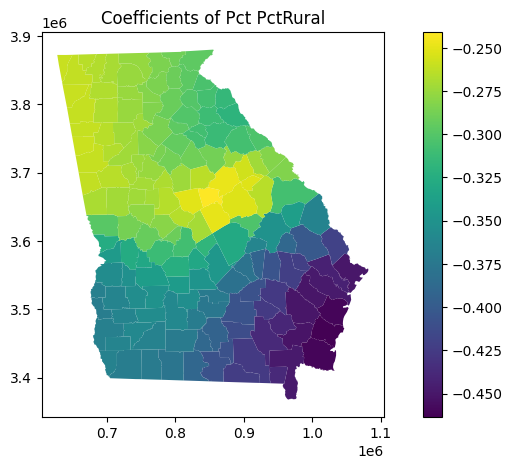

In [11]:
from matplotlib import colors

ax = georgia_shp.plot(column=gwr_results.params[:,3],figsize=(10,5),legend=True, 
                     linewidth=0.0,aspect=1)

plt.title("Coefficients of Pct PctRural",fontsize=12)

Write some mapping codes to visualize the parameter estimate surfaces altogether. We need to join the GWR result with the county GeoDataFrame.

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def param_plots(result, gdf, names=[], filter_t=False):
    
    #Size of the plot. Here we have a 2 by 2 layout.
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.ravel()
    
    k = gwr_results.k
    
    #The max and min values of the color bar.
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("coolwarm")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.9,0.1),ncolors=256)
    
    
    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap="bwr",norm=norm,linewidth=0.1,edgecolor='white',aspect=1)
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='grey', ax=axs[j],linewidth=0.1,edgecolor='white',aspect=1)
        
        #plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

#### Here are the maps of parameter estimates obtained from GWR. Each represent the spatial relationship between each predictor and PctBach.

- Positive (negative) relationships are shown in red (blue).
- Stronger (weaker) relationship has a darker (lighter) color.

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_55115/1271372694.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("coolwarm")


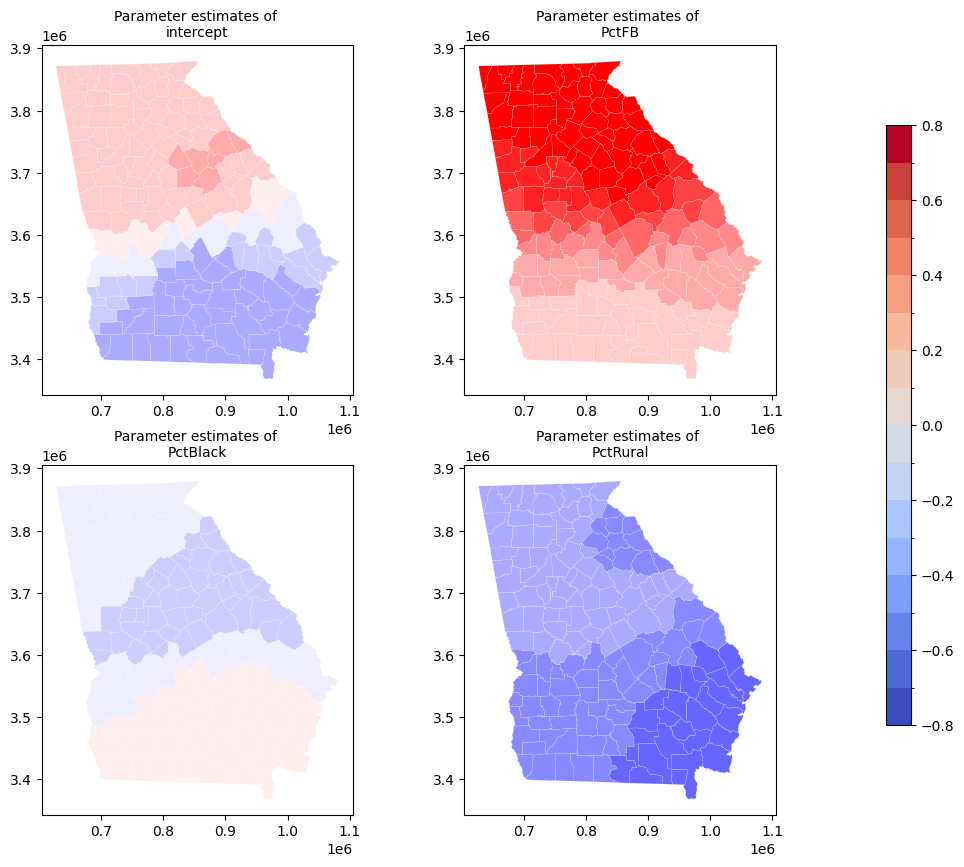

In [13]:
param_plots(gwr_results, georgia_shp, names=['intercept','PctFB', 'PctBlack', 'PctRural'])

Now lets checkout the residuals of from the GWR model.

In [14]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(georgia_shp)

#row standardization
w.transform = 'R'

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_55115/876426650.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(georgia_shp)


In [15]:
georgia_moran = Moran(gwr_results.resid_response.reshape(-1), 
                         w, permutations = 199) #199 permutations
georgia_moran.I

0.040101374209262214

Often we see that the residuals from the GWR model have random patterns, which indicates that both spatial heterogenity and autocorrelation are being accounted for. The local intercept plays a role in accounting for the spatial autocorrelation, which acts similar to the autoregressive error component in a spatial error model.



### GWR inference

Local coefficient significance

#### Here are the maps of **SIGNIFICANT (p<0.05)** parameter estimates. The significance test has been adjusted to account for the multiple testing issue. 
Insinificant parameters are masked out in grey. You can find that, for example, the association between PctBlack and PctBach is actually insignificant despite the pattern we see in the regression coefficients.


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_55115/1271372694.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("coolwarm")


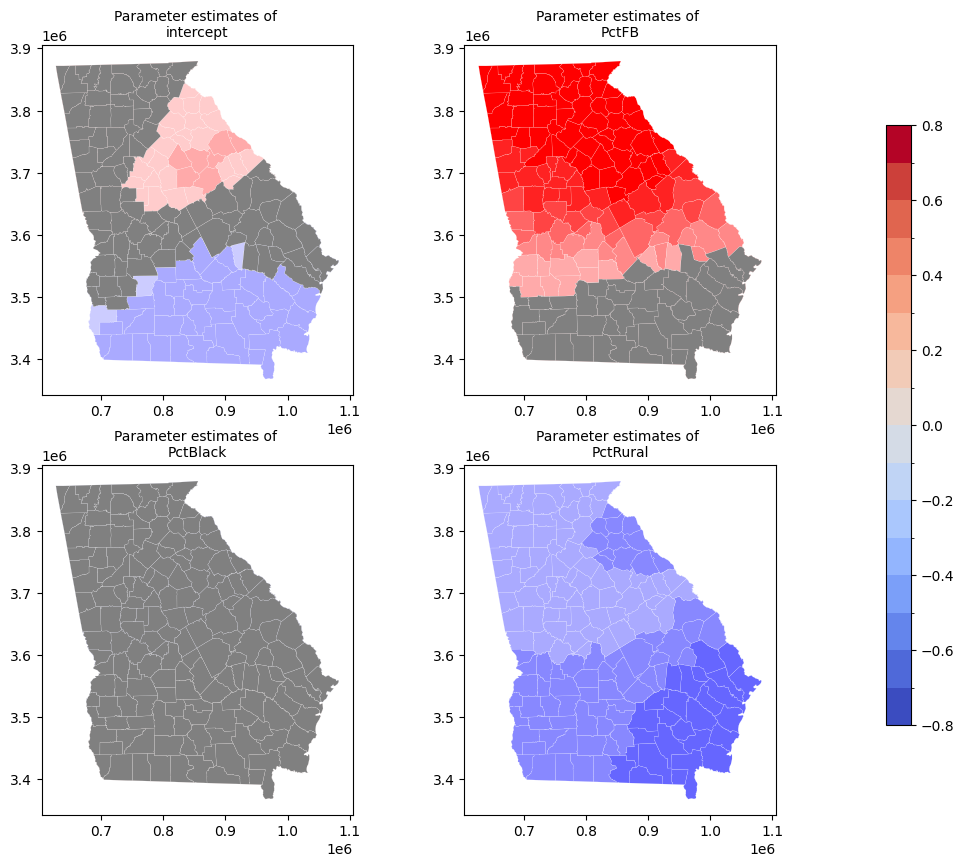

In [16]:
param_plots(gwr_results, georgia_shp,names=['intercept',
                                            'PctFB', 'PctBlack', 'PctRural'],
            
            filter_t=True)